# 研究目的

# 研究区域
藏东南地区


# 研究流程
## 初始化
首先初始化环境，初始化环境后oggm会读取默认参数。
后续可以通过`cfg.PARAMS`进行修改参数

In [5]:
from oggm import cfg,utils
cfg.initialize()

2023-10-30 09:21:29: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-10-30 09:21:29: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-10-30 09:21:29: oggm.cfg: Multiprocessing: using all available processors (N=16)


可以修改oggm的参数，如下

In [6]:

cfg.PARAMS['use_multiprocessing'] = True

2023-10-30 09:21:29: oggm.cfg: Multiprocessing switched ON after user settings.


## workflow设置
oggm需要指定一个working_dir，也就是一个文件夹用于储存冰川的预处理，处理结果等文件。

In [10]:
from oggm import workflow
path = utils.mkdir("/home/fanyu/OGGM_FILE",reset=True)
cfg.PATHS["working_dir"] = path

## 指定冰川目录
通过rgi的id来指定我们需要研究的冰川，冰川数据会被储存在冰川目录（glacier directory）中，这是一种特定的格式。可以储存包括冰川属性等信息。
The init_glacier_directories task will allways be the very first task to call for all your OGGM experiments. （init_glacier_directories很重要，在开始我们的冰川任务前通常都需要使用这个来下载和初始化我们的冰川目录）“file and attribute manager” for single glaciers


In [11]:
rgi_ids = ['RGI60-11.01328', 'RGI60-11.00897']
# Where to fetch the pre-processed directories
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5'
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=4, prepro_base_url=base_url, prepro_border=80)

2023-10-30 09:32:38: oggm.workflow: init_glacier_directories from prepro level 4 on 2 glaciers.
2023-10-30 09:32:38: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2 glaciers


gdirs是workflow.init_glacier_directories的结果，由于设置了两个以上的冰川id，因此gdirs分别是不同ID的冰川的冰川目录的列表。

In [28]:
type(gdirs), type(gdirs[0])
gdir = gdirs[1]  # take Unteraar glacier
print('Path to the DEM:', gdir.get_filepath('dem'))
gdir
gdir.rgi_date  # date at which the outlines are valid

Path to the DEM: /home/fanyu/OGGM_FILE/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00897/dem.tif


2003

graphic是oggm编写的一个用于绘制图表的模组，它可以根据冰川目录来搜集需要的数据，然后进行绘图。

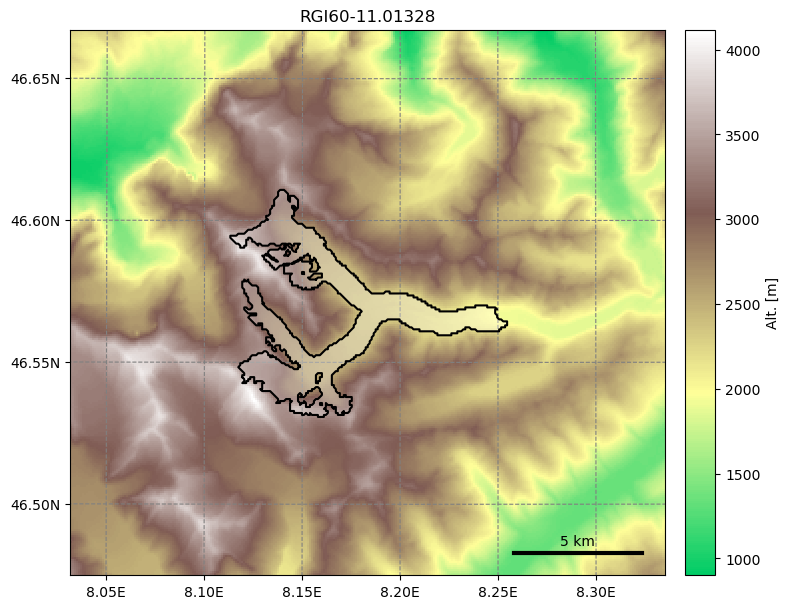

In [18]:
from oggm import graphics
graphics.plot_domain(gdir, figsize=(8, 7))

## task运行
entity task是指对某个冰川进行的某项处理，可以通过`workflow.execute_entity_task(taskname)`进行任务的执行，只要把task的名字输入，taskname也可以是一个包含了多个任务的列表，这样oggm就会对冰川依次执行多个任务。

In [21]:
from oggm import tasks
workflow.execute_entity_task(tasks.glacier_masks, gdirs)

2023-10-30 09:51:12: oggm.workflow: Execute entity tasks [glacier_masks] on 2 glaciers


[None, None]

In [22]:
print('Path to the masks:', gdir.get_filepath('gridded_data'))

Path to the masks: /home/fanyu/OGGM_FILE/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.01328/gridded_data.nc


可以使用列表以此执行任务

In [31]:
list_tasks = [
         tasks.compute_centerlines,
         tasks.initialize_flowlines,
         tasks.compute_downstream_line,
         ]
for task in list_tasks:
    # The order matters!
    workflow.execute_entity_task(task, gdirs)

2023-10-30 09:53:59: oggm.workflow: Execute entity tasks [compute_centerlines] on 2 glaciers
2023-10-30 09:53:59: oggm.workflow: Execute entity tasks [initialize_flowlines] on 2 glaciers
2023-10-30 09:53:59: oggm.workflow: Execute entity tasks [compute_downstream_line] on 2 glaciers


使用graphics可以对处理的结果进行绘制，比如下方的中心线计算任务，graphic会根据冰川目录找到它的中心线计算结果，然后根据设定好的参数进行绘图。

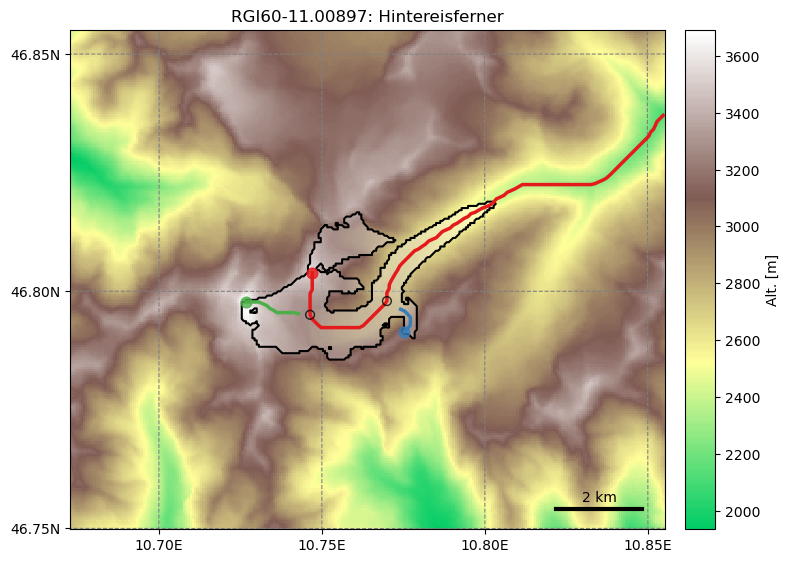

In [32]:
graphics.plot_centerlines(gdir, figsize=(8, 7), use_flowlines=True, add_downstream=True)

In [33]:
import os
print(os.listdir(gdir.dir))

['inversion_flowlines.pkl', 'inversion_input.pkl', 'climate_historical.nc', 'model_diagnostics_historical.nc', 'flowline_catchments.tar.gz', 'log.txt', 'mb_calib.json', 'centerlines.pkl', 'catchments_intersects.tar.gz', 'intersects.tar.gz', 'dem_source.txt', 'model_geometry_historical.nc', 'model_flowlines.pkl', 'diagnostics.json', 'dem.tif', 'outlines.tar.gz', 'inversion_output.pkl', 'gridded_data.nc', 'downstream_line.pkl', 'glacier_grid.json', 'geometries.pkl']


可以执行更多的任务，这些任务执行后便会把结果记录在working_dir的glacier_dir中

In [34]:
list_tasks = [
         tasks.catchment_area,
         tasks.catchment_width_geom,
         tasks.catchment_width_correction,
         tasks.compute_downstream_bedshape
         ]
for task in list_tasks:
    # The order matters!
    workflow.execute_entity_task(task, gdirs)

2023-10-30 09:58:54: oggm.workflow: Execute entity tasks [catchment_area] on 2 glaciers
2023-10-30 09:58:55: oggm.workflow: Execute entity tasks [catchment_width_geom] on 2 glaciers
2023-10-30 09:58:56: oggm.workflow: Execute entity tasks [catchment_width_correction] on 2 glaciers
2023-10-30 09:58:56: oggm.workflow: Execute entity tasks [compute_downstream_bedshape] on 2 glaciers


对结果进行绘制

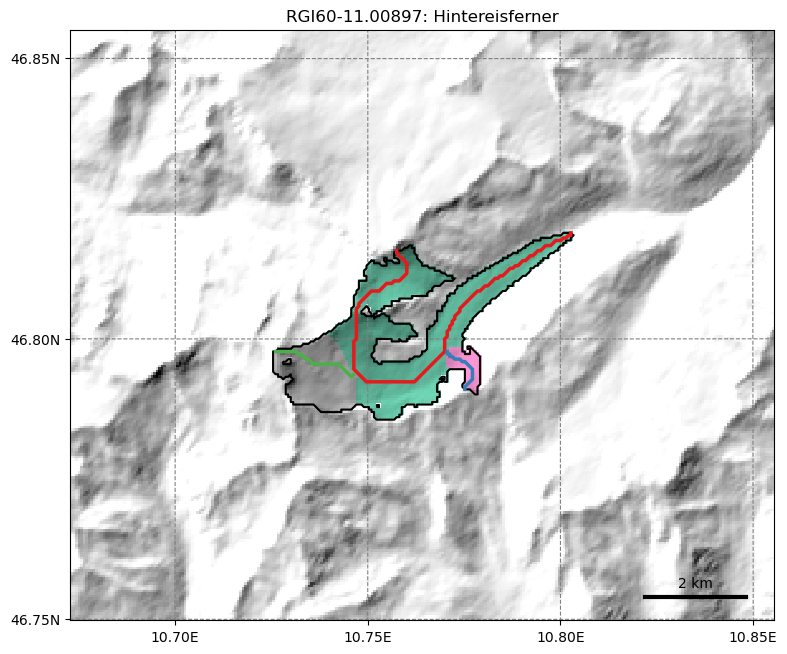

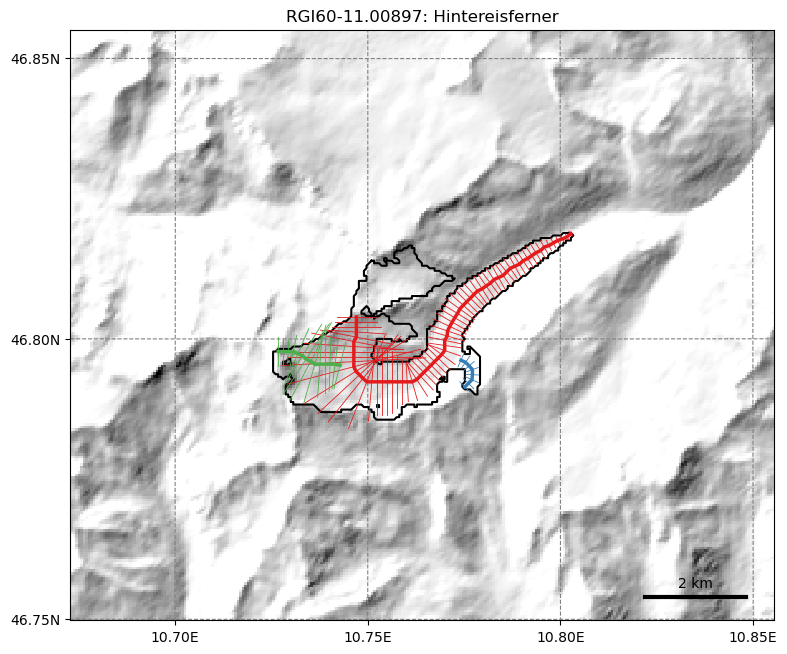

In [35]:
graphics.plot_catchment_areas(gdir, figsize=(8, 7))#流域绘制
graphics.plot_catchment_width(gdir, corrected=True, figsize=(8, 7))#绘制横截面

### 冰厚反演
在计算了冰流线和进行质量平衡校准后，可以通过质量平衡定律来反演冰厚

In [36]:
list_talks = [
         tasks.apparent_mb_from_any_mb,  # This is a preprocessing task
         tasks.prepare_for_inversion,  # This is a preprocessing task
         tasks.mass_conservation_inversion,  # This does the actual job
         tasks.filter_inversion_output  # This smoothes the thicknesses at the tongue a little
         ]
for task in list_talks:
    workflow.execute_entity_task(task, gdirs)

2023-10-30 10:19:43: oggm.workflow: Execute entity tasks [apparent_mb_from_any_mb] on 2 glaciers
2023-10-30 10:19:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 2 glaciers
2023-10-30 10:19:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 2 glaciers
2023-10-30 10:19:43: oggm.workflow: Execute entity tasks [filter_inversion_output] on 2 glaciers


可以对冰厚反演结果进行绘图，冰厚的计算是在冰流线上进行的。

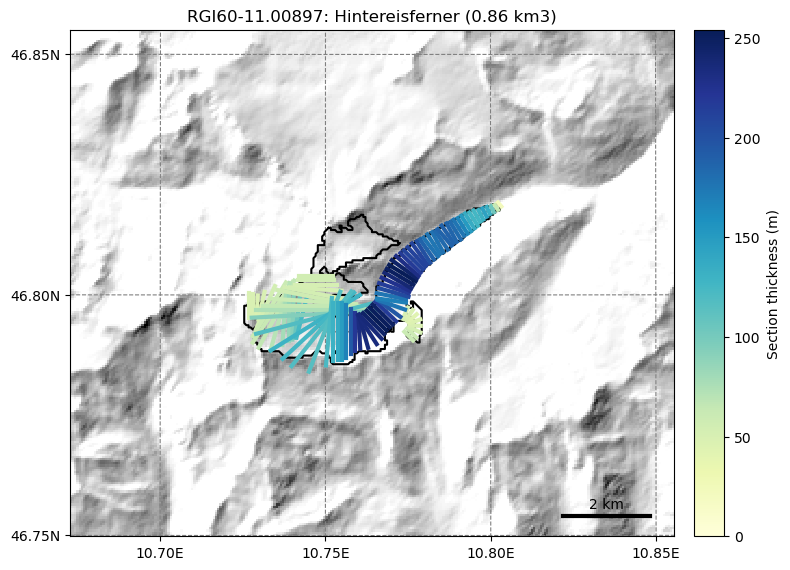

In [37]:
graphics.plot_inversion(gdir, figsize=(8, 7))

冰川厚度的反演对参数**A**很敏感,研究或许可以关注一下如何优化这些参数。

In [38]:
cfg.PARAMS['inversion_glen_a']

2.4e-24